In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

In [44]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [50]:
def label_offset(ax, axis="y"):
    if axis == "y":
        fmt = ax.yaxis.get_major_formatter()
        ax.yaxis.offsetText.set_visible(False)
        set_label = ax.set_ylabel
        label = ax.get_ylabel()

    elif axis == "x":
        fmt = ax.xaxis.get_major_formatter()
        ax.xaxis.offsetText.set_visible(False)
        set_label = ax.set_xlabel
        label = ax.get_xlabel()

    def update_label(event_axes):
        offset = fmt.get_offset()
        if offset == '':
            set_label("{}".format(label))
        else:
            set_label("{} ({})".format(label, offset))
        return

    ax.callbacks.connect("ylim_changed", update_label)
    ax.callbacks.connect("xlim_changed", update_label)
    ax.figure.canvas.draw()
    update_label(None)
    return


Need a spectrum of the disk in order to parameterize. Will do that now in matlab. 

In [60]:
path_to_spec = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'MATLAB',
    'disk_simulations'
    )

disk_spec = sio.loadmat(os.path.join(
    path_to_spec,
    'bare_disk_spectrum.mat'
    ))


In [61]:
hw = 1240/disk_spec['enei'][0]
spec = disk_spec['sca']
spec.shape

(50, 3)

In [62]:
hw.shape

(50,)

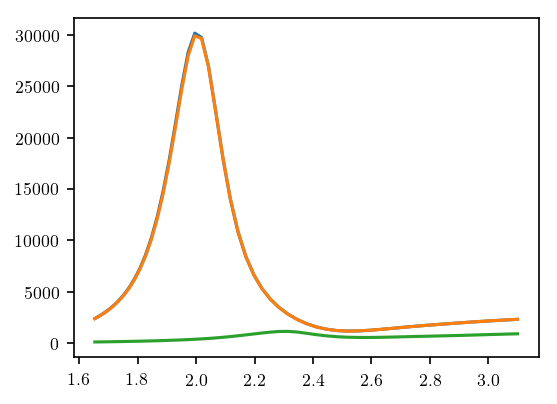

In [63]:
plt.figure(figsize=(4,3), dpi=150)
for i, spectrum in enumerate(spec.T):
    plt.plot(hw, spectrum)

This is a JC spectrum, should do Drude as well for rigor

In [64]:

def ret_fit_scat_1(hbarw, eps_inf, hbarw_p, hbargamma, half_height, radius):
    
    a_x = half_height
    a_yz = radius
    
    return cp.long_sigma_scat_ret_pro_ellip(
        hbarw/hbar, 
        eps_inf, 
        hbarw_p/hbar, 
        hbargamma/hbar, 
        eps_b, 
        a_x*cm_per_nm, 
        a_yz*cm_per_nm)


In [65]:
#+++++++++++++++++++++++++++++++++++++++++++++
def absol_oblate_cost_f(params, *args):
    x=args[0]
    y=args[1]
    
    ## Parameters
#     eps_inf=params[0]
#     w_p=params[1]
#     gamma=params[2]
#     a_x = params[3]
#     a_yz = params[4]
    
    ## Convert data from nm^2 to cm^2
    y = y*(1e-14) ## cm^2/nm^2
    
    ## Define fit function
    yfit = ret_fit_scat_1(x, *params)

    ## Define scale of cost func for rescaling to order unity 
    cost_scale = 1e-10
    
    return (y-yfit).ravel() / cost_scale



def oblate_fit_result(x, params):
    
    amp = params[-1]
    phys_params = params[:-1]
    
    yfit=ret_fit_scat_1(x, *phys_params)
    
    return yfit/yfit.max() * amp

In [66]:
sigma_scat_data = spec[:,0]

array([12.35045979,  9.28346156,  0.14991186, 20.        , 41.74973417])

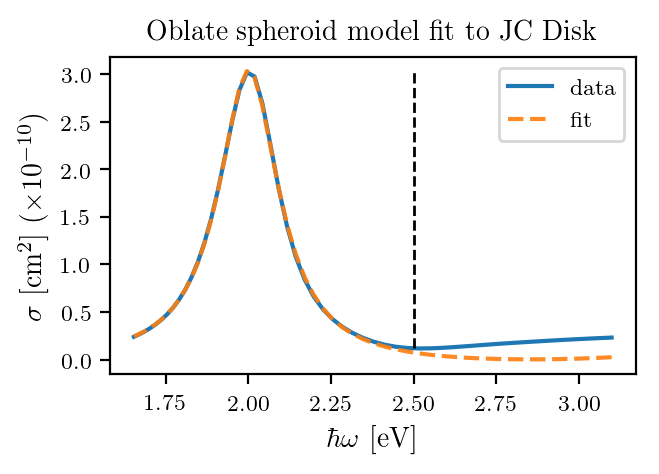

In [67]:
#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([11.6817827 ,  9.56022562,  0.8554153, 30.24119972/2, 80.24119972/2,])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 2.5
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    absol_oblate_cost_f, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
    bounds=(
        [0,   0,  0,  10, 35],
        [18, 20, 1,  20, 45],
        ),
    x_scale=[10,10,1E-1,10, 10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hw, *result['x'])
ini_guess = ret_fit_scat_1(hw, *ini_guess_params)


## Build figure
plt.figure()

## Plot Data
plt.plot(hw, sigma_scat_data*1E-14, label='data')
plt.plot(
    [2.5, 2.5],
    [np.min(sigma_scat_data*1E-14), np.max(sigma_scat_data*1E-14)],
    ls='dashed',
    c='k',
    lw=1)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='fit',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

# ## Plot initial guess
# plt.plot(
#     hw, 
#     ini_guess, 
#     label='initial guess',
#     ls='dotted', 
# #     marker='.', 
#     markersize=1, 
#     alpha=.9)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Oblate spheroid model fit to JC Disk')
plt.legend()

ax = plt.gca()
label_offset(ax, "y")

result['x']

Things that would be interesting to compare, 
- How does fitting just long axis compare to simultaneous fit of long and short axis, like in the rod case
    - this could be a significant difference between the rod and disk situations that I had not previously acknowledged. 
    - If I do not constrain the fit to the long axis the radii tend to equalize. 

Should also maybe check z orientation?

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


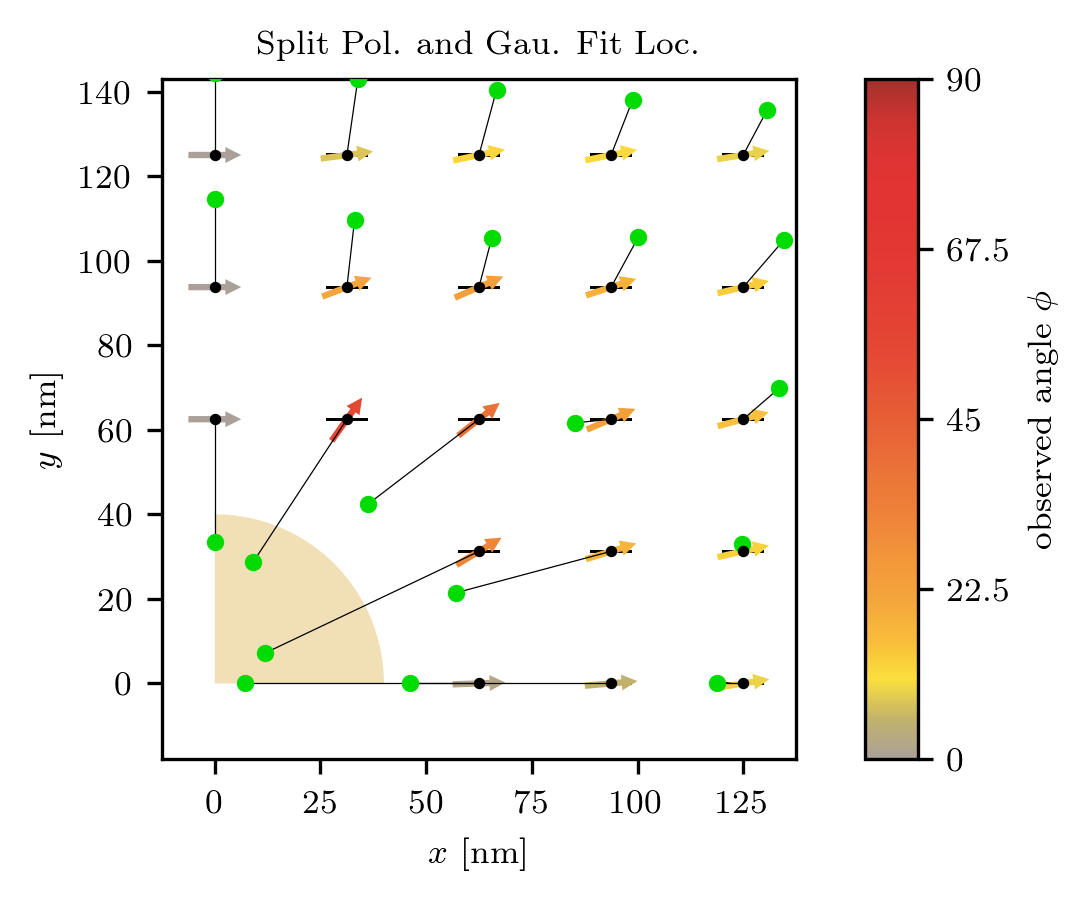

In [10]:
locations, angles = fit.fixed_ori_mol_placement(
    mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='disk_JC',
    simulation_file_name='CurlyDiskJC_NoSub_dipDrive_E')
sim_inst.trial_images = sim_inst.calculate_BEM_fields()

sim_inst.plot_mispol_map_wMisloc()


 initial guess for molecule 0 location: (0.10181834403373026,10.041602321057415)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.10181834403373026 
 ini_y,  10.041602321057415 
 self.quel_a,  51.74973417 
 self.quel_c,  51.74973417 

In quenching zone? True
Params modified, OG params: (0.10181834403373026, 10.041602321057415, array([0.08651505]))
but now they are: (0.524697277037313, 51.74707411470851, array([0.08651505]))

 initial guess for molecule 1 location: (0.013925849433767547,127.26282823079339)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.013925849433767547 
 ini_y,  127.26282823079339 
 self.quel_a,  51.74973417 
 self.quel_c,  51.74973417 

In quenching zone? False

 initial guess for molecule 2 location: (0.012836889317208822,154.0321882354493)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.012836889317208822 
 ini_y,  154.0321882354493 
 self.quel_a,  51.74973417 
 self.quel_c,  51.74973417 

In quench

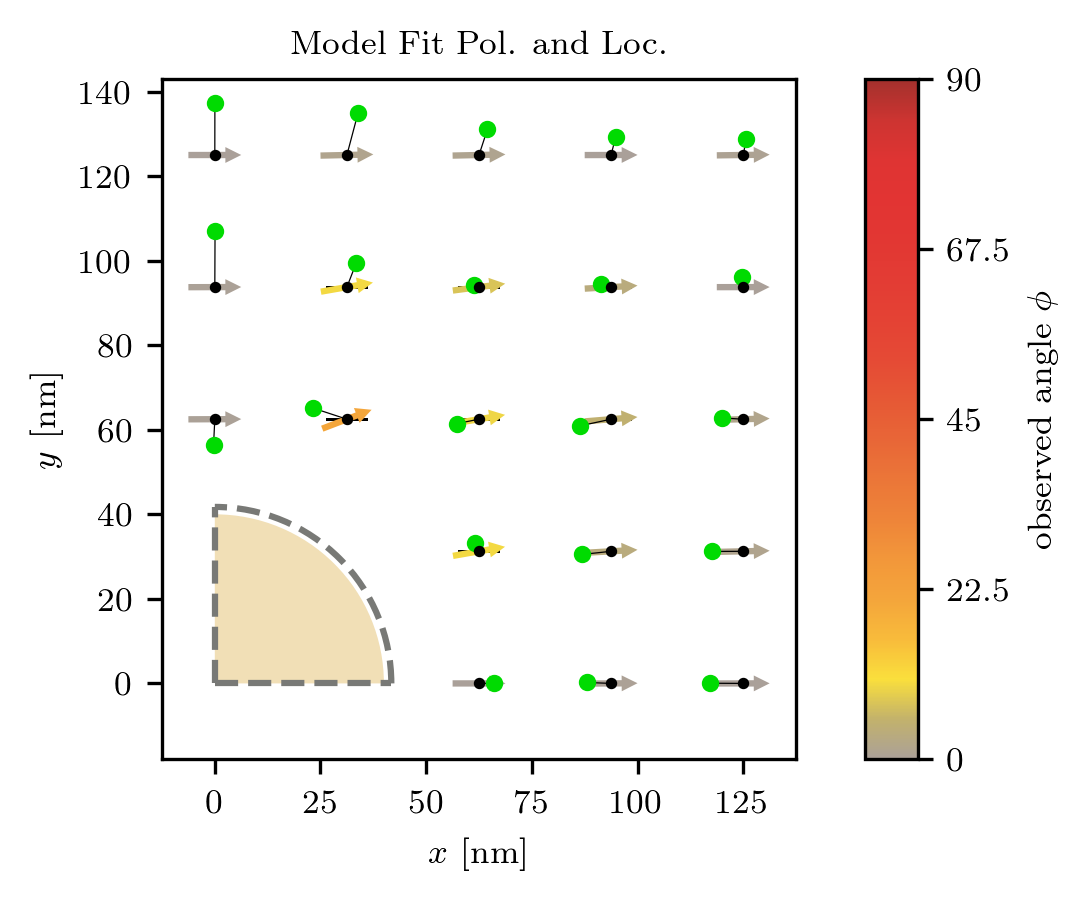

In [11]:
# Model fit
# Gaussian guess, checked

fit_inst = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='disk_JC'
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
fit_inst.plot_fit_results_as_quiver_map(sim_inst)   

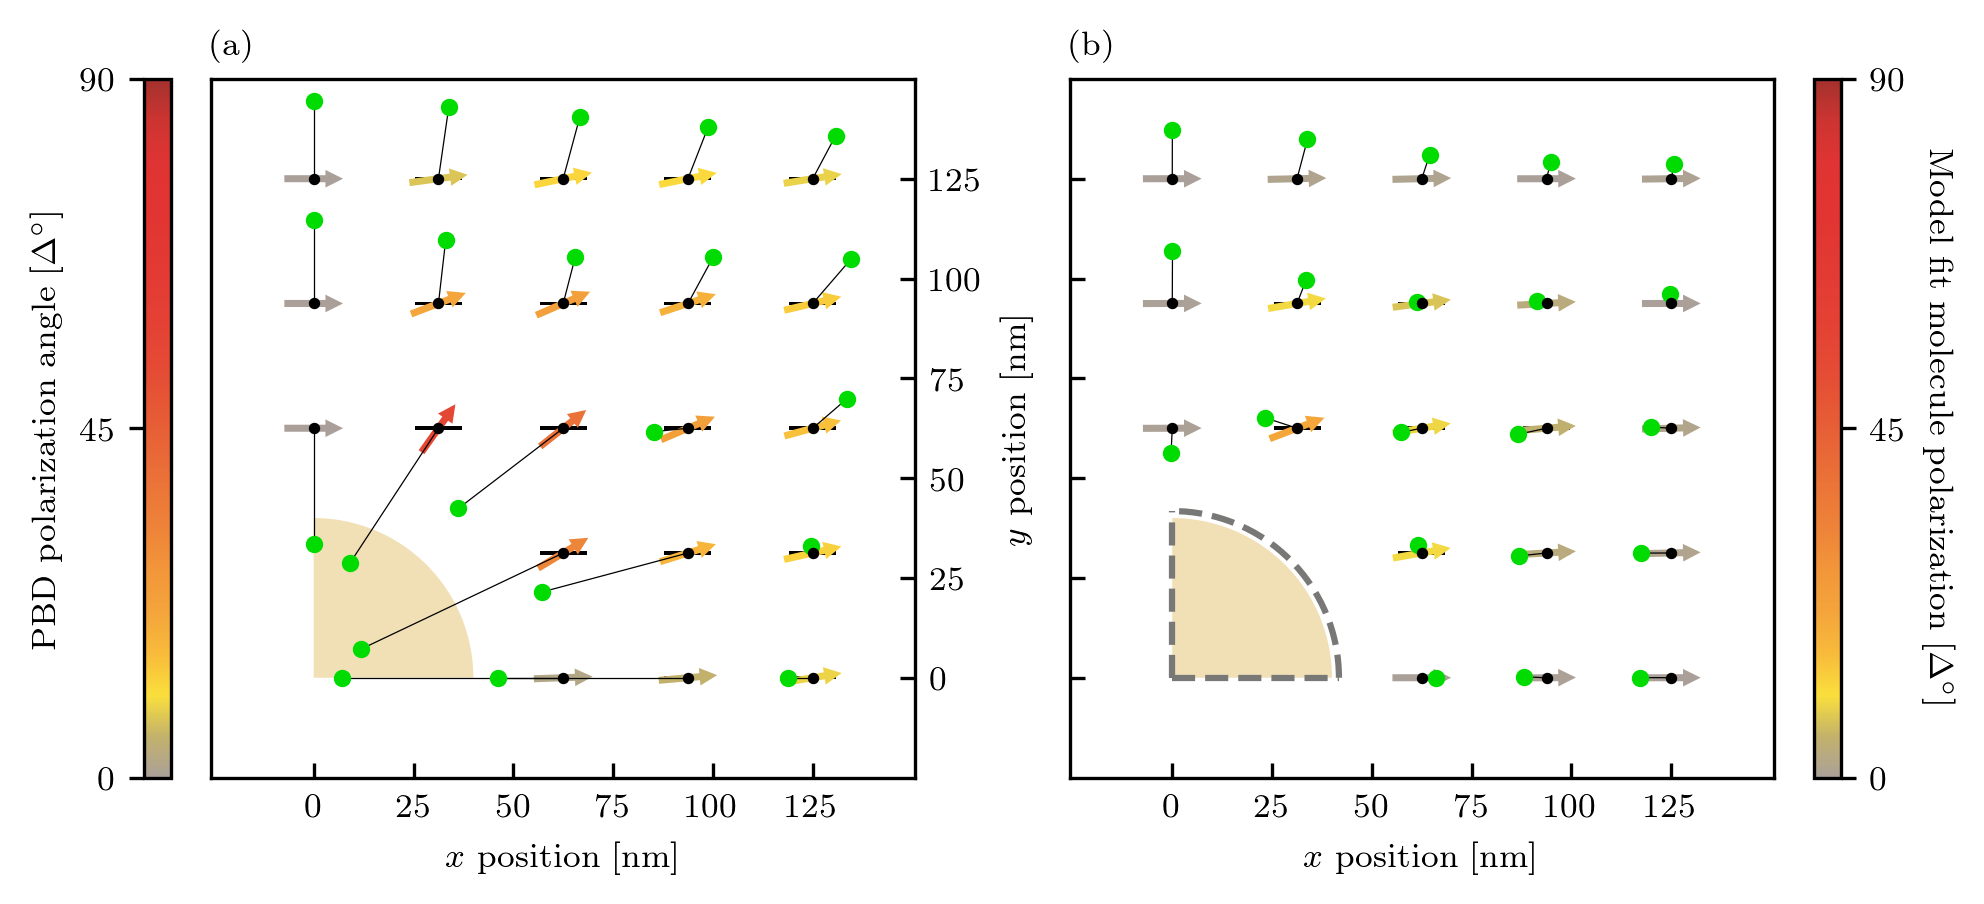

In [12]:
fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)

In [15]:
sim_inst.drive_energy_eV

2.0

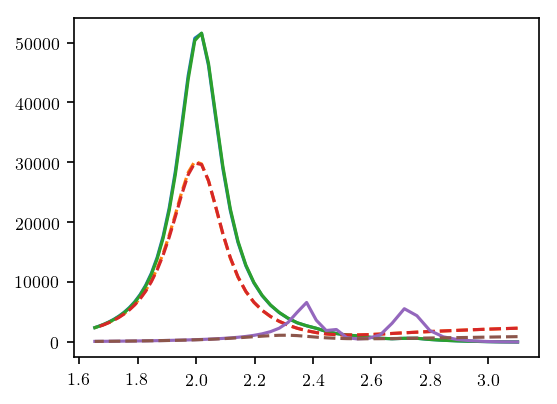

In [54]:
diskDrude_spec = sio.loadmat(os.path.join(
    path_to_spec,
    'bare_disk_spectrum_Drude.mat'
    ))

hw = 1240/diskDrude_spec['enei'][0]
spec = diskDrude_spec['sca']
spec.shape

plt.figure(figsize=(4,3), dpi=150)
for i, spectrum in enumerate(spec.T):
    plt.plot(hw, spectrum)
    plt.plot(hw, disk_spec['sca'].T[i], ls='--')

array([45.2282245 , 20.13645854,  0.09593564,  2.9856273 , 47.09151229])

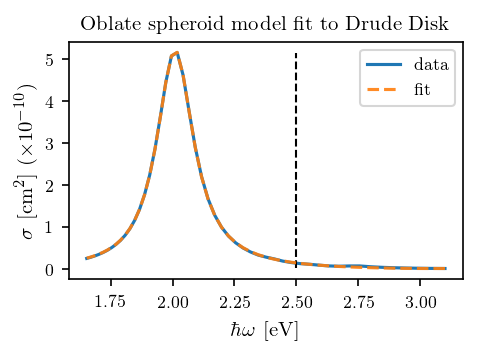

In [55]:
sigma_scat_data = spec[:,0]

#+++++++++++++++++++++++++++++++++++++++++++++
# ini_guess_params=np.array([3.48260965,  6.72763066,  0.65709936, 29.24119972, 79.24119972])
ini_guess_params=np.array([11.6817827 ,  9.56022562,  0.08554153, 30.24119972/2, 79.24119972/2,])
# ini_guess_params=np.array([13.99604932, 10.05123876,  0.28443696, 36.1993746]) 
# ini_guess_params=np.array([15.14244193,  8.4634295 , -0.16462349, 64.3292537 , 28.24427368])
params0=ini_guess_params   #parameter guess

## Reduce fit range
energy_cutoff = 2.5
args=[hw[hw<energy_cutoff], sigma_scat_data[hw<energy_cutoff]]
# for c in Ts:
#   args.append(c) 
args=tuple(args)   #doesn't work if args is a list!!

## Perform minimization of cost function
result=opt.least_squares(
    absol_oblate_cost_f, 
    params0, 
    ftol=1e-15,
    xtol=1e-15, 
    gtol=1e-15, 
    args=args,
#     bounds=(
#         [0,   0,  0,  5, 35],
#         [25, 20, 1,  20, 45],
#         ),
    x_scale=[10,10,1E-1,10, 10],
    )
                         
#+++++++++++++++++++++++++++++++++++++++++++++
fit_result = ret_fit_scat_1(hw, *result['x'])
ini_guess = ret_fit_scat_1(hw, *ini_guess_params)


## Build figure
plt.figure(dpi=150)

## Plot Data
plt.plot(hw, sigma_scat_data*1E-14, label='data')
plt.plot(
    [2.5, 2.5],
    [np.min(sigma_scat_data*1E-14), np.max(sigma_scat_data*1E-14)],
    ls='dashed',
    c='k',
    lw=1)

## Plot best fit
plt.plot(
    hw, 
    fit_result, 
    label='fit',
    ls='--', 
#     marker='.', 
    markersize=1, 
    alpha=.9)

# ## Plot initial guess
# plt.plot(
#     hw, 
#     ini_guess, 
#     label='initial guess',
#     ls='dotted', 
# #     marker='.', 
#     markersize=1, 
#     alpha=.9)

plt.xlabel(r'$\hbar\omega$ [eV]')
# plt.xlim([1.4, 2.7])
plt.ylabel(r'$\sigma$ [cm$^2$]')
plt.title(r'Oblate spheroid model fit to Drude Disk')
plt.legend(fontsize=8)


ax = plt.gca()
label_offset(ax, "y")

result['x']

## Now Drude, no fit bounds

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


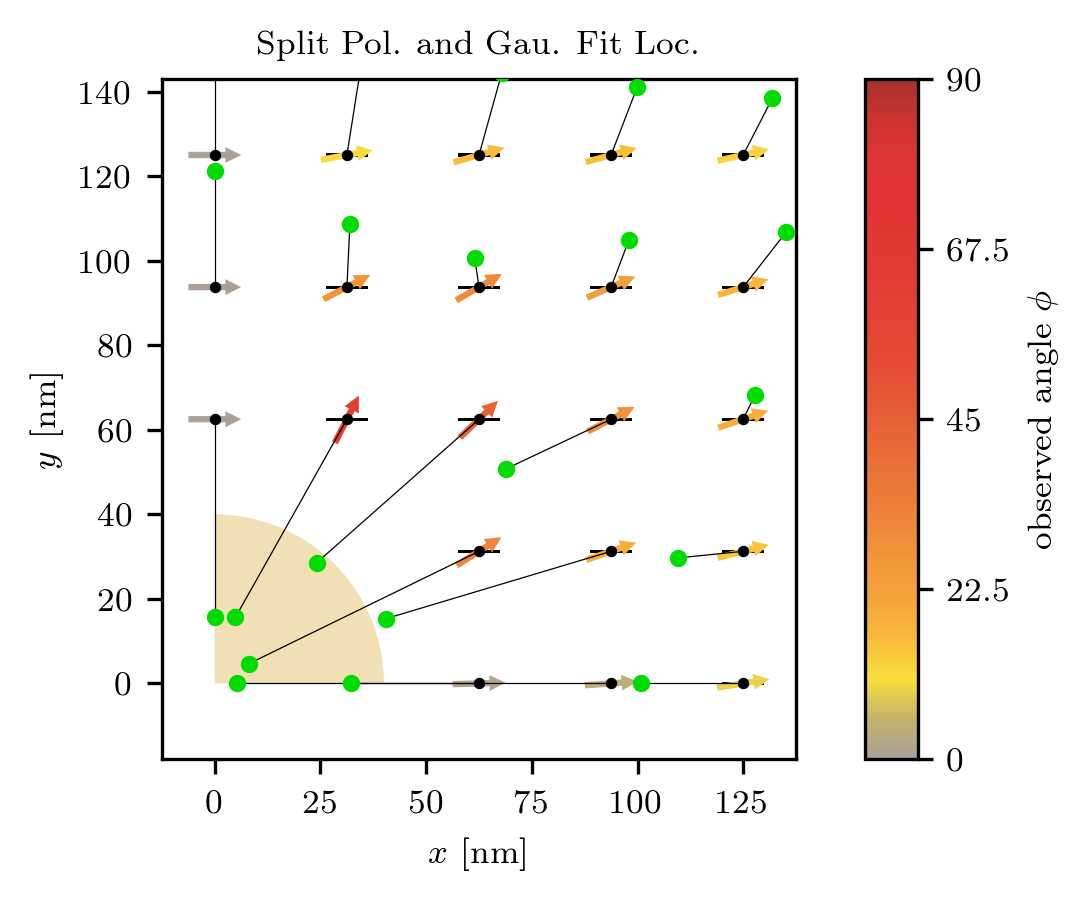

In [17]:
locations, angles = fit.fixed_ori_mol_placement(
    mol_grid_pts_1D=5, x_max=125, y_max=125)
sim_inst_Drude = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='disk_Drude_noFitBounds',
    simulation_file_name='CurlyDiskDrude_NoSub_dipDrive_E')
sim_inst_Drude.trial_images = sim_inst_Drude.calculate_BEM_fields()

sim_inst_Drude.plot_mispol_map_wMisloc()


 initial guess for molecule 0 location: (0.04508164461616864,2.8477720880675936)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.04508164461616864 
 ini_y,  2.8477720880675936 
 self.quel_a,  57.09151229 
 self.quel_c,  57.09151229 

In quenching zone? True
Params modified, OG params: (0.04508164461616864, 2.8477720880675936, array([1.18194791]))
but now they are: (0.9036737309761398, 57.08435993638857, array([1.18194791]))

 initial guess for molecule 1 location: (0.020638471869743217,97.79531548716822)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.020638471869743217 
 ini_y,  97.79531548716822 
 self.quel_a,  57.09151229 
 self.quel_c,  57.09151229 

In quenching zone? False

 initial guess for molecule 2 location: (0.023268046221054262,153.51053441859253)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  0.023268046221054262 
 ini_y,  153.51053441859253 
 self.quel_a,  57.09151229 
 self.quel_c,  57.09151229 

In quenc

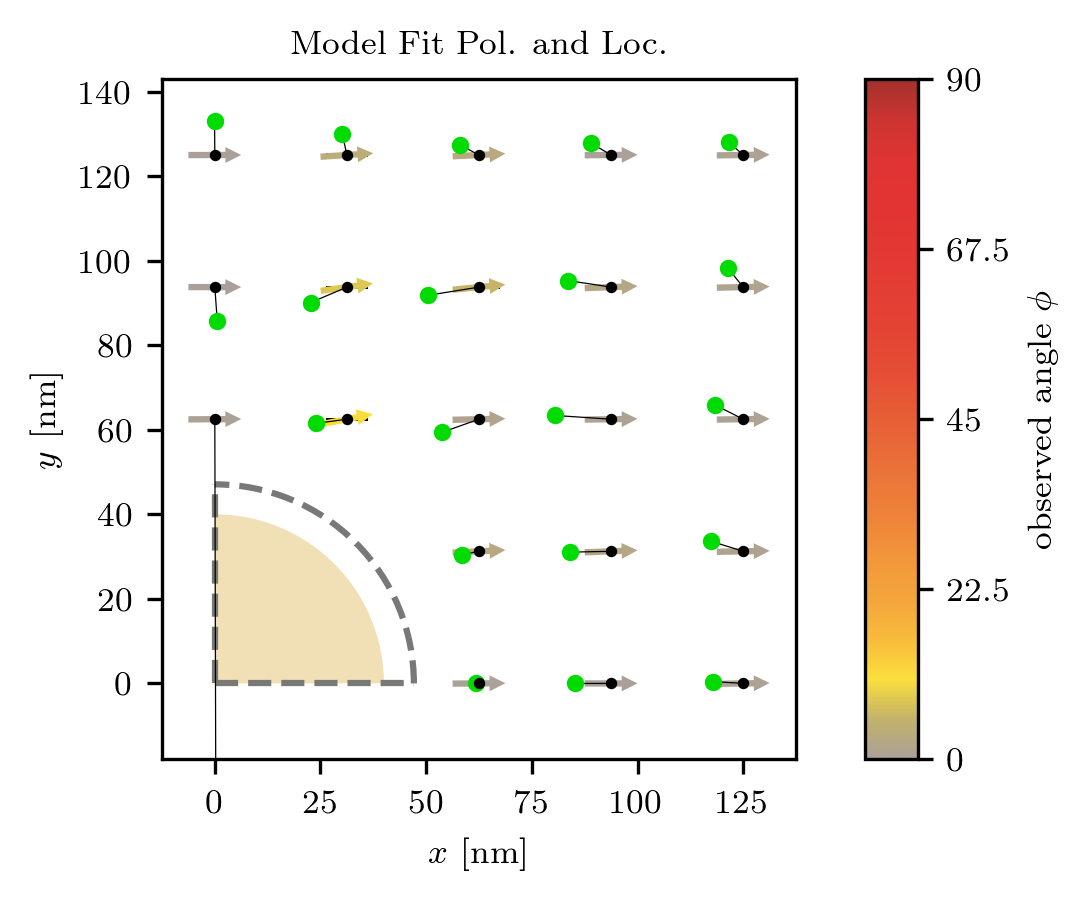

In [18]:
# Model fit
# Gaussian guess, checked

fit_inst_Drude = fit.FitModelToData(
    sim_inst_Drude.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='disk_Drude_noFitBounds'
    )
the_fit = fit_inst_Drude.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
fit_inst_Drude.plot_fit_results_as_quiver_map(sim_inst_Drude)   

Drude sim, no fit bounds

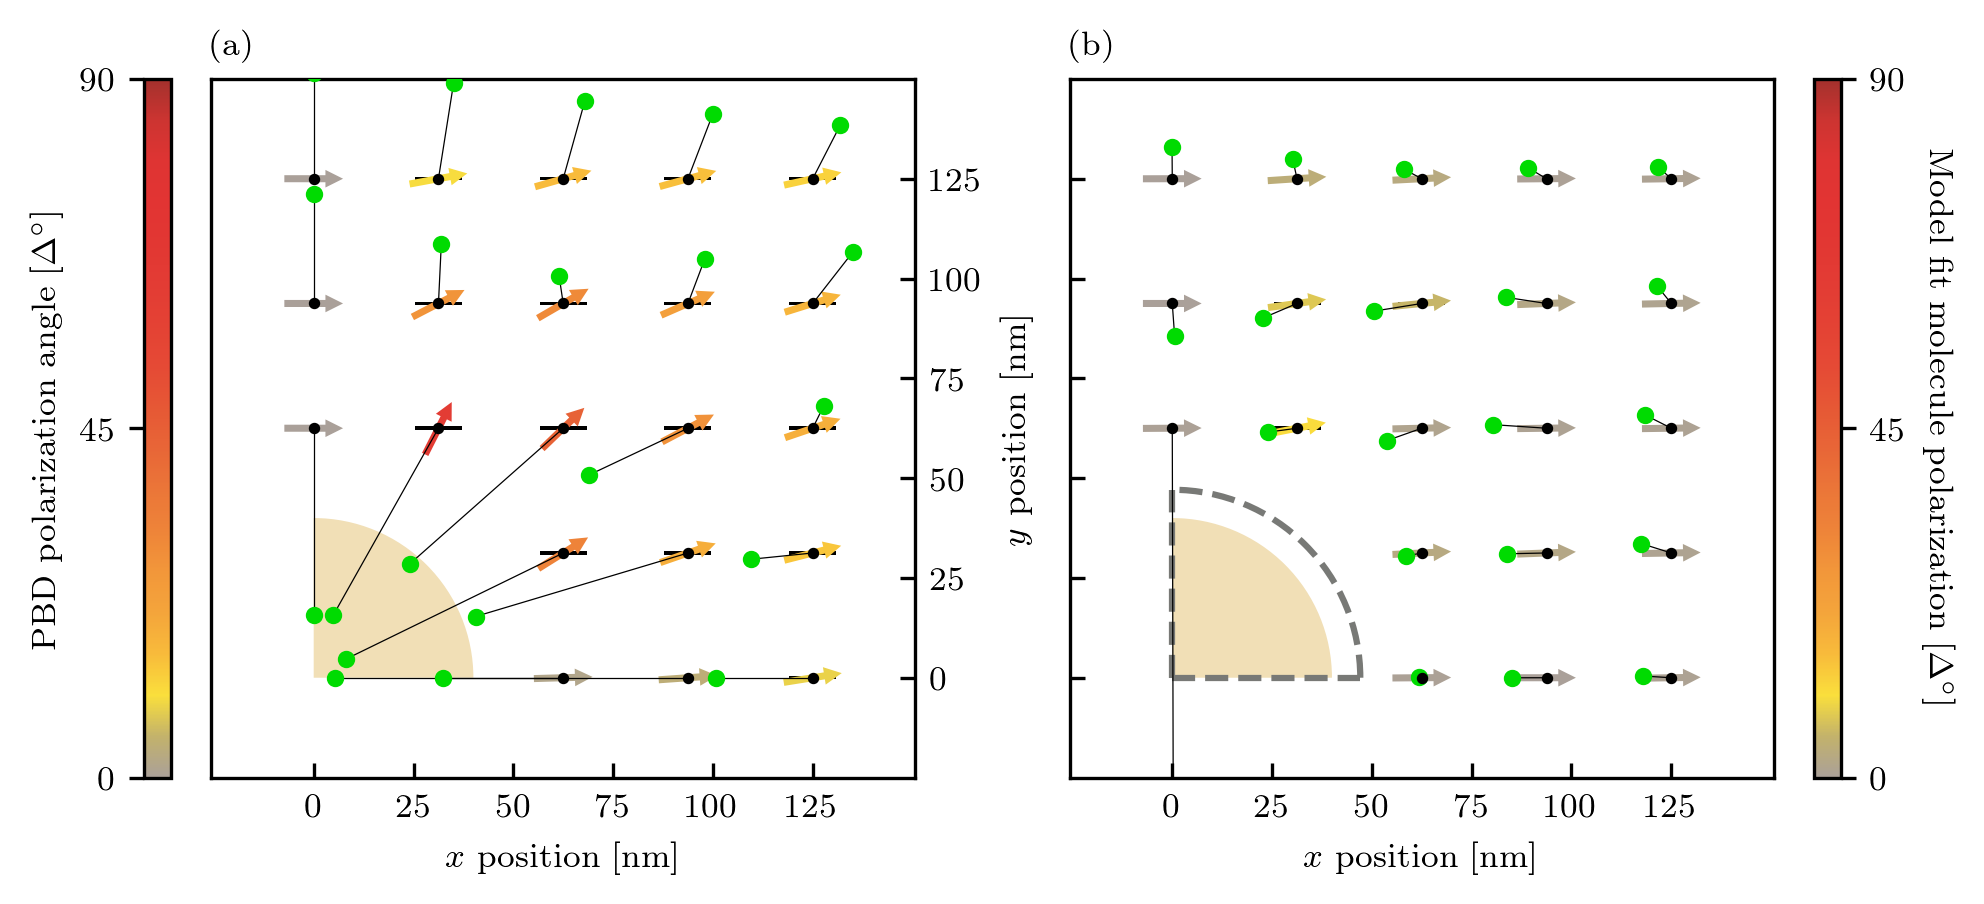

In [25]:
fig5 = bem.fig5(sim_inst_Drude, fit_inst_Drude, draw_quadrant=True)
# fig5.suptitle('Drude')

JC sim with fit bounds

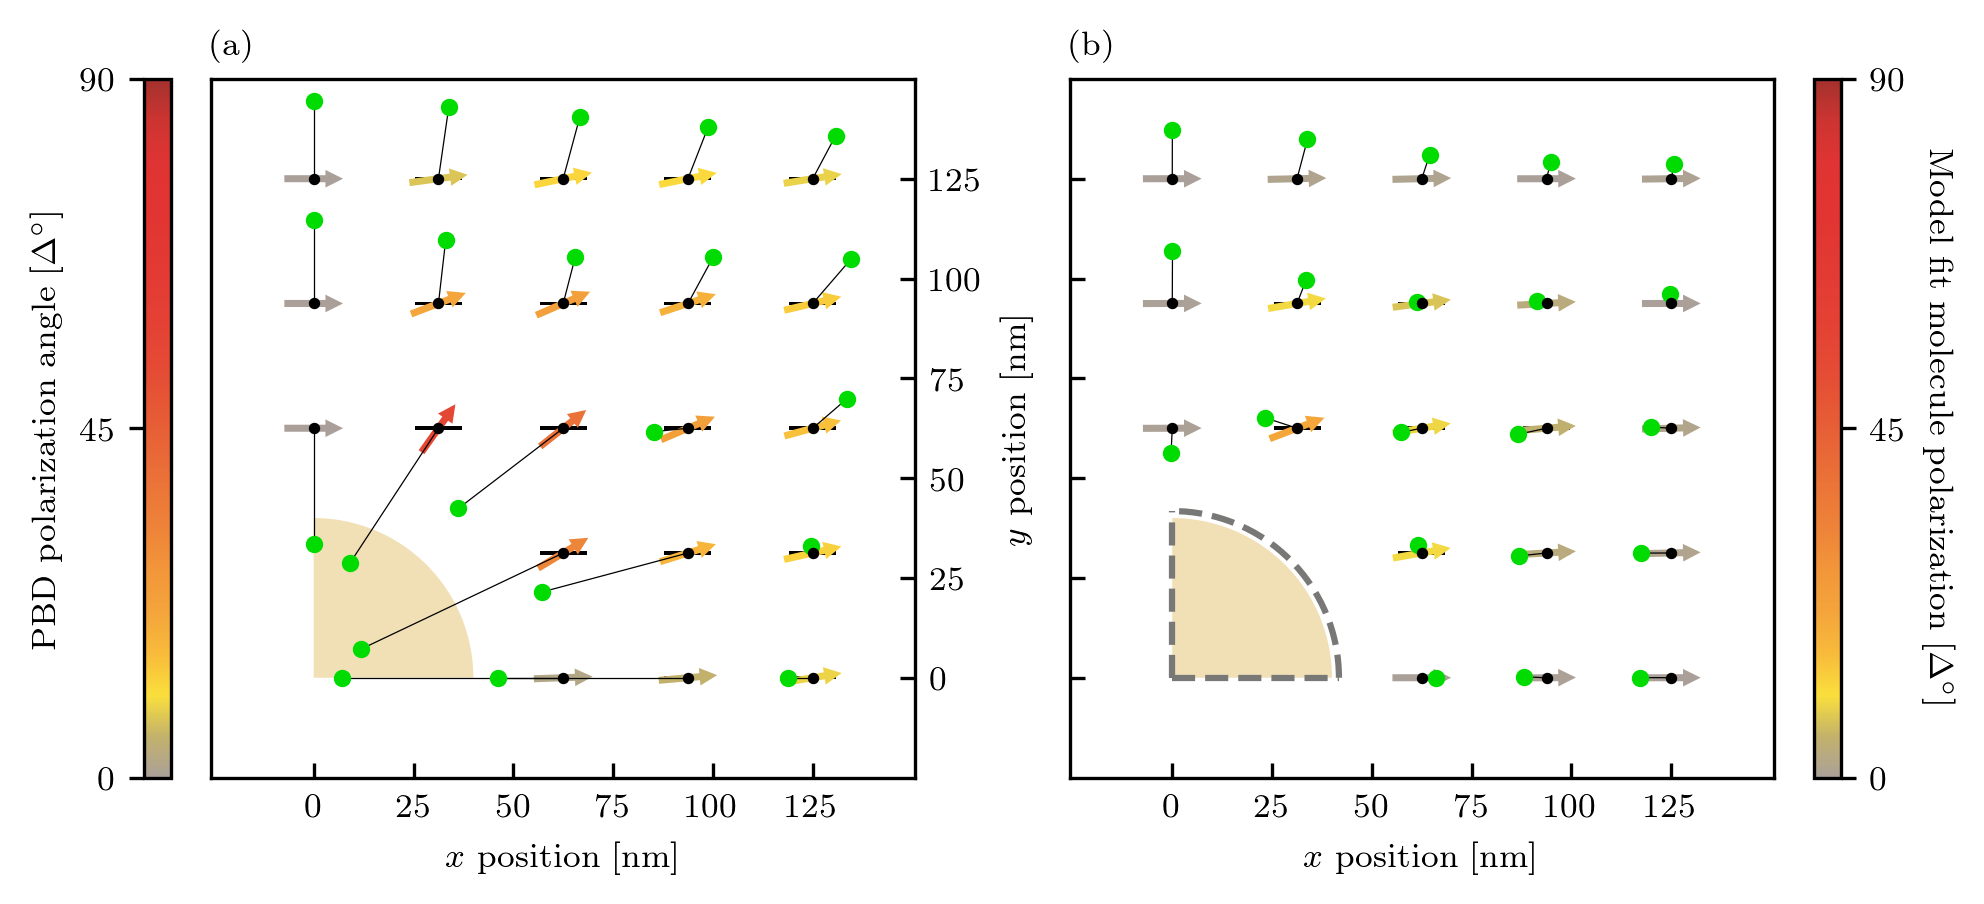

In [12]:
fig5 = bem.fig5(sim_inst, fit_inst, draw_quadrant=True)